In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.auto import tqdm

from photonic_planar_code import *
from graph_operations import min_weight_syndrome_matching
from visualization import plot_matchings, plot_planar_code

def single_shot_correction(code, z_state=0, pathfinding=None, plot_error=False):
    code.advance(1)
    error = None
    for i in [0, 1]:
        syndrome = code.measure_syndrome(lattice=i)
        lattice = code.lattices[i]
        matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding=pathfinding)
        for path in paths:
            try:
                lattice.apply_edge_operators(path)
            except Exception as e:
                error = e
        if i == 0: code_copy = deepcopy(code)
        lattice.reset_error_model()
    if error is None:
        try:
            errored = lattice.detect_logical_errors(initial_z=z_state)
        except Exception as e:
            error = e
    if error is not None or (plot_error and errored):
        plot_planar_code(code_copy, plot_dual=True, show_errors=True, show_syndrome=True)
        plot_matchings(lattice, syndrome)
        plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=True)
        print(paths)
    if error is not None:
        raise error
    return errored


def logical_error_rate(p, r, L, samples=int(1e3), verbose=True, pathfinding=None, track_z=False, plot_errors=0):
    code = PhotonicPlanarCode(L, pz=p, rz=r)
    logical_errors = []
    z_state = 0
    for _ in range(samples):
        z_error = single_shot_correction(code, z_state, pathfinding=pathfinding, plot_error=plot_errors>0)
        if track_z and z_error:
            z_state = int(not bool(z_state))
        if not track_z:
            code.reset()
        logical_errors.append(z_error)
        if z_error and plot_errors > 0:
            plot_errors -= 1
    return np.array(logical_errors)


def linear_sweep(L, p_array, r_array, samples_per_point=int(1e3), plot_errors=0, **kwargs):
    pr_errors = []
    p_range = tqdm(
        p_array,
        desc=f'L={L}: Sweeping over p values from {np.min(p_array)} to {np.max(p_array)}'
    ) if len(p_array) > 10 else p_array
    for p in p_range:
        r_errors = []
        r_range = tqdm(
            r_array,
            desc=f'L={L}: Sweeping over r values from {np.min(r_array)} to {np.max(r_array)}'
        ) if len(r_array) > 10 else r_array
        for r in r_range:
            error_array = logical_error_rate(p, r, L, samples=samples_per_point, verbose=False, plot_errors=plot_errors, **kwargs)
            r_errors.append(error_array)
            if plot_errors > 0:
                plot_errors = max(plot_errors - np.sum(error_array), 0)
        pr_errors.append(np.stack(r_errors, axis=0))
    return np.stack(pr_errors, axis=0)

In [2]:
SAVE_DIR = 'temp'
SAVED_FILES = []

In [7]:
p_array=[0.01]
r_array=np.linspace(0, 0.3, 102)

for L in [4, 8, 12]:
    arr = linear_sweep(L, p_array=p_array, r_array=r_array, samples_per_point=int(1e3), pathfinding='manhattan')
    fname = os.path.join(SAVE_DIR, f'{L}.csv')
    np.savetxt(fname, arr.flatten())

L=4: Sweeping over r values from 0.0 to 0.3:   0%|          | 0/102 [00:00<?, ?it/s]

L=8: Sweeping over r values from 0.0 to 0.3:   0%|          | 0/102 [00:00<?, ?it/s]

L=12: Sweeping over r values from 0.0 to 0.3:   0%|          | 0/102 [00:00<?, ?it/s]

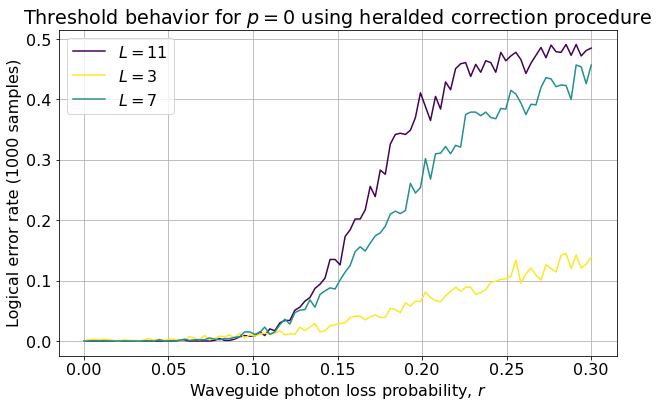

In [8]:
import matplotlib as mpl

plt.rcParams.update({'font.size': 16})
BATCH = 4

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.grid(True)
ax.set_xlabel('Waveguide photon loss probability, $r$')
ax.set_ylabel('Logical error rate (1000 samples)')
ax.set_title('Threshold behavior for $p=0$ using heralded correction procedure')
#ax.set_xscale('log')
#ax.set_yscale('log')

files = []
for fname in os.listdir(SAVE_DIR):
    if not fname.endswith('.csv'):
        continue
    fpath = os.path.join(SAVE_DIR, fname)
    L = int(fname.split('.')[0])
    files.append([L, fpath])

min_l = min(files)[0]
max_l = max(files)[0]
norm = mpl.colors.Normalize(vmin=min_l, vmax=max_l, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis_r)
ps = r_array
for L, fpath in files:
    error_array = np.loadtxt(fpath).reshape(ps.size, -1)
    mean_errors = error_array.mean(axis=-1)
    #ax.fill_between(xvals, yvals+error_stdev[-1], yvals-error_stdev[-1], alpha=0.3, zorder=1)
    ax.plot(ps, mean_errors, color=mapper.to_rgba(L), label=f'$L={L-1}$', zorder=2)
    

#ax.vlines(0.11, *ax.get_ylim(), color='black', linestyle='dashed', zorder=3)
ax.legend()